<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v12: Near-zero Gradients Explainer
This notebook begins a whole new idea - that I can find direct explanations for computed gradients, and offer explicit explanations for gradients trending towards zero.

Specifically, given sufficient activation, weights, and gradient information surrounding a particular layer at a particular point during training, I can re-execute all of the steps that occurred to calculate the gradients. In so doing, I can break down the steps and identify which set of steps led to zero and near-zero gradients.

In practice I don't have 100% of the information needed, and I also cannot support the same level of flexibility that TF does with its polymorphic layer abstraction. But there's still a lot that can be done, because:
* most layers fall into a very small set of common layers, eg: deep, convolution.
* I can design the "explainer" to degrade gracefully, presenting as much information as it can obtain.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 704ef35
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
import train_explainer as te
from importlib import reload
reload(tot)
reload(te)

Cloning into 'repo'...
remote: Enumerating objects: 434, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 434 (delta 45), reused 52 (delta 25), pack-reused 352 (from 1)
Receiving objects: 100% (434/434), 22.62 MiB | 11.74 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Already up to date.


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [2]:
import train_observability_toolkit_test
import train_explainer_test
reload(train_observability_toolkit_test)
reload(train_explainer_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()
train_explainer_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


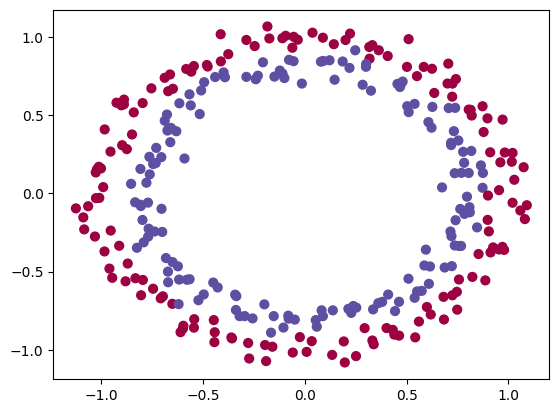

In [4]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [ ]:
model = binary_classification_model('he_normal')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,611 (162.54 KB)

 Trainable params: 41,411 (161.76 KB)

 Non-trainable params: 200 (800.00 B)

## Training with Data collection
The explainer requires that we collect full data for the layer in question and those on either side.
So let's run a training sequence with detailed data collection.

We'll run for a few epochs so that we can pick an iteration that has some interesting characteristics. Also, for this very simple model, we don't have a good idea in advance which layer might lead to some interesting results, and it isn't very big, so we'll just collect all data across all layers.



In [5]:
# This will take a couple of minutes to run
collection_sets = [{}]
variables = tot.VariableHistoryCallback(per_step=True, before_updates=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
activity = tot.ActivityHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))

start = tf.timestamp()
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 1.39s/epoch: loss: 0.6086  
Epoch    20 - 814.35ms/epoch: loss: 0.3900  
Epoch    30 - 890.42ms/epoch: loss: 0.1445  
Epoch    40 - 988.43ms/epoch: loss: 0.2209  
Epoch    50 - 1.54s/epoch: loss: 0.4009  
Epoch    60 - 1.04s/epoch: loss: 0.1091  
Epoch    70 - 766.69ms/epoch: loss: 0.0150  
Epoch    80 - 1.04s/epoch: loss: 0.0089  
Epoch    90 - 925.22ms/epoch: loss: 0.0062  
Epoch   100 - 819.40ms/epoch: loss: 0.0818  
Total training time: 102.63 secs


Now let's take a look at the summary statistics and find a layer of interest and a point in time that's interesting.

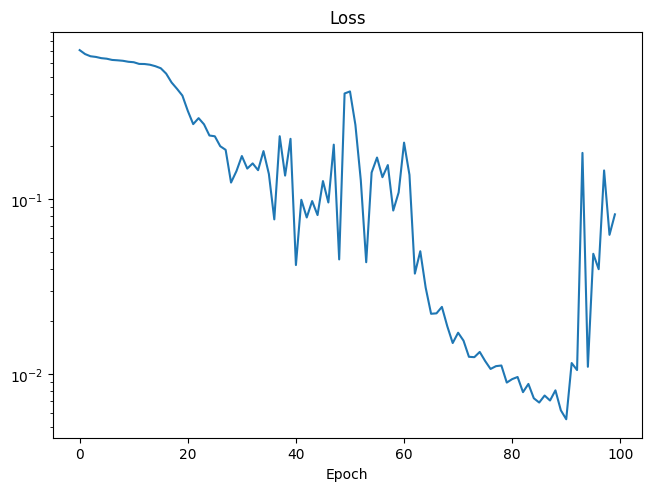

In [6]:
plot_fit(history)

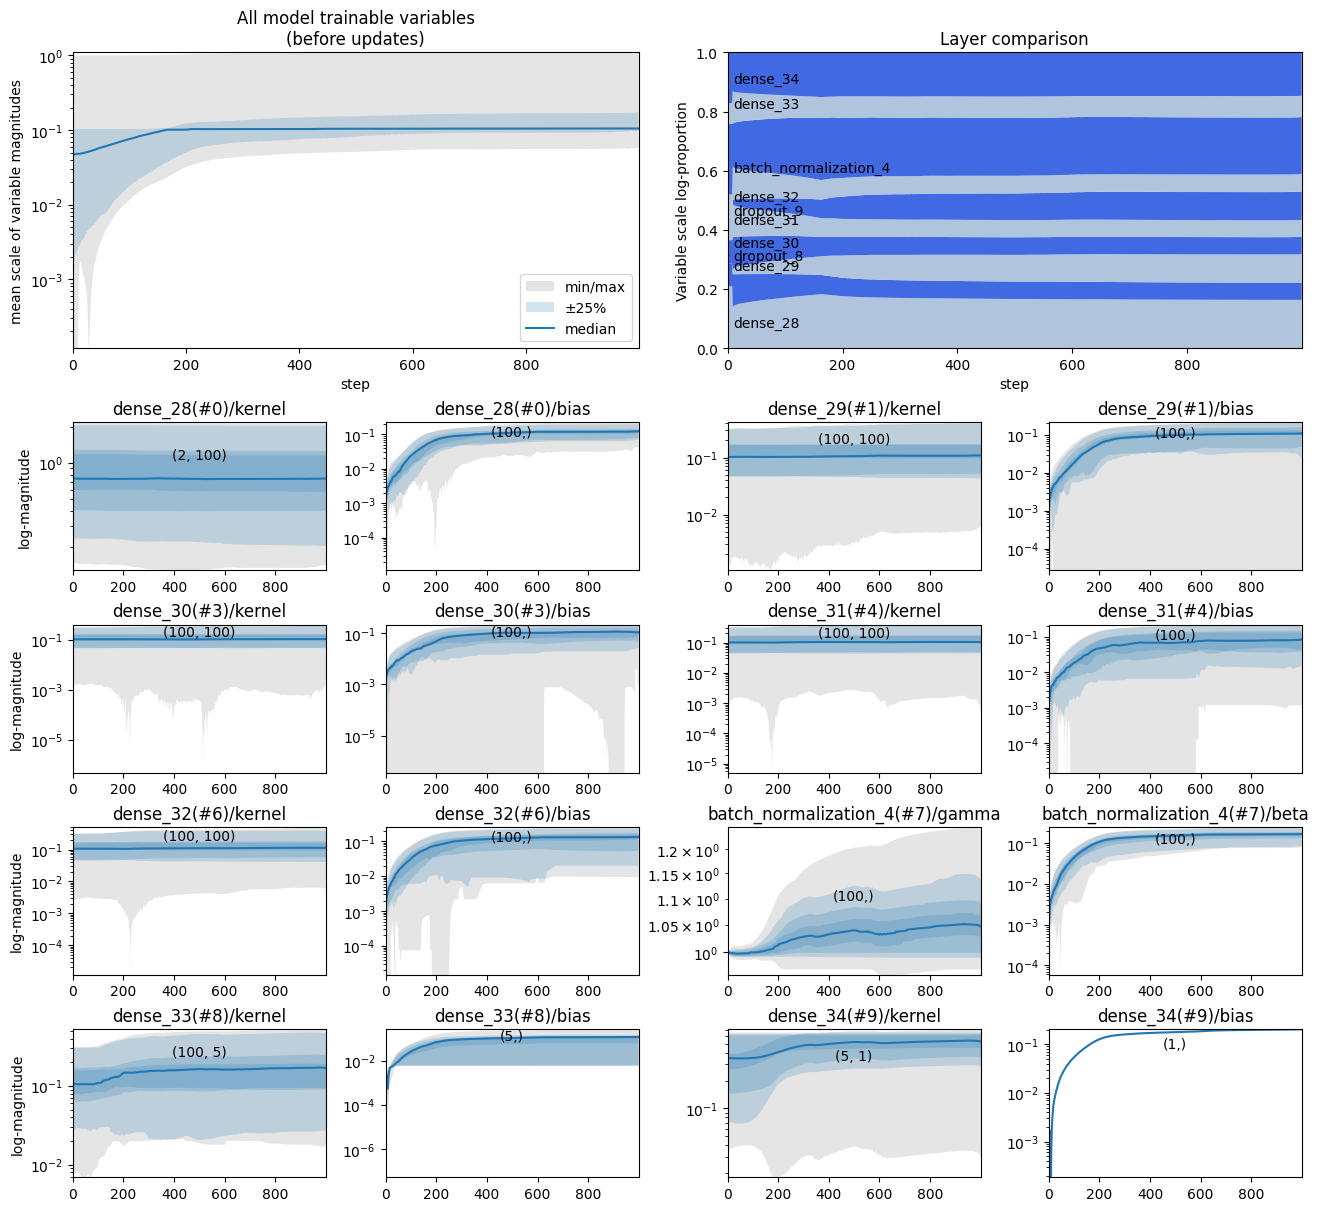

In [7]:
tot.plot_variable_history(variables, magnitudes=True)

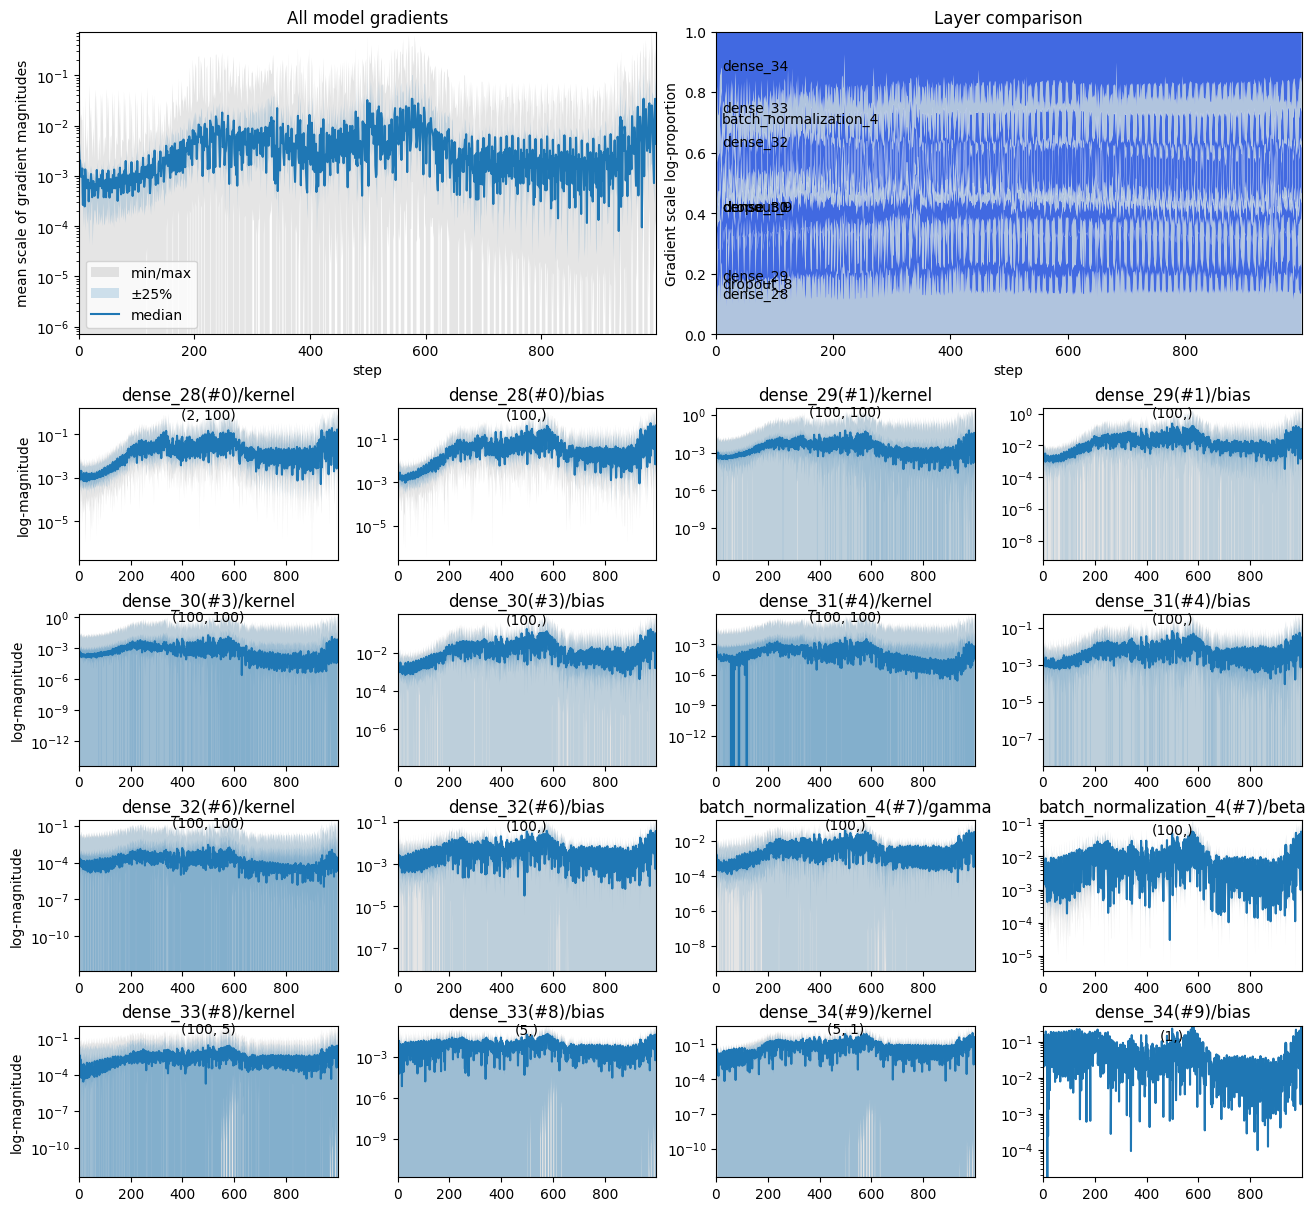

In [8]:
tot.plot_gradient_history(gradients, magnitudes=True)

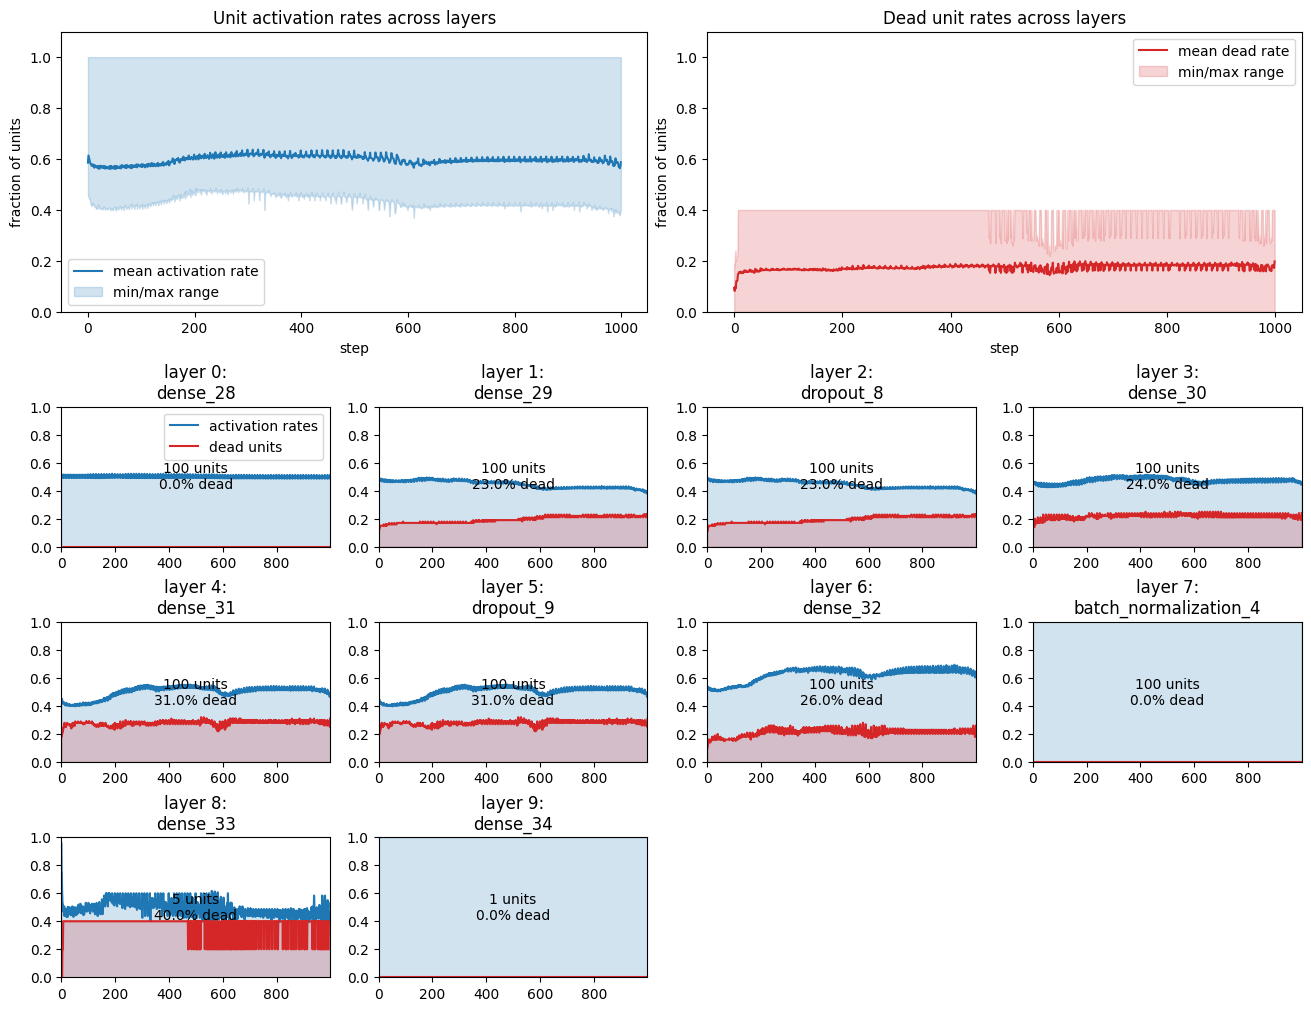

In [10]:
tot.plot_activity_rate_history(activity)

## Point of interest selection
From the above we can conclude that:
* This particular run didn't produce anything very exciting.
* The variable #6 (zero-based), the kernel of layer #4, experienced some zero gradients briefly during its first 200 iterations.

Let's narrow down on an iteration of interest.

In fact, as we'll see, the graphs above are not yet indicating the situation well enough. That variable actually has a large number of its individual values that stay at exactly zero throughout training.

In [24]:
selected_var_idx = 5

In [22]:
gradients.gradient_stats[selected_var_idx]

,0.0,12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0
0,-0.096625,-0.003450,-0.000694,0.0,0.0,0.0,0.000588,0.003953,0.097315
1,-0.039204,-0.001695,-0.000244,0.0,0.0,0.0,0.000489,0.001965,0.028837
2,-0.043221,-0.002030,-0.000518,0.0,0.0,0.0,0.000105,0.001358,0.044641
3,-0.032480,-0.001157,-0.000210,0.0,0.0,0.0,0.000260,0.001199,0.022724
4,-0.018006,-0.000860,-0.000124,0.0,0.0,0.0,0.000191,0.000914,0.021678
...,...,...,...,...,...,...,...,...,...
995,-0.023789,-0.000938,-0.000075,0.0,0.0,0.0,0.000000,0.000116,0.042126
996,-0.714995,-0.027254,-0.002701,0.0,0.0,0.0,0.000000,0.004224,0.832697
997,-1.150438,-0.051089,-0.006938,0.0,0.0,0.0,0.000000,0.011513,1.081842
998,-0.957203,-0.022530,-0.002587,0.0,0.0,0.0,0.000000,0.002739,1.177802


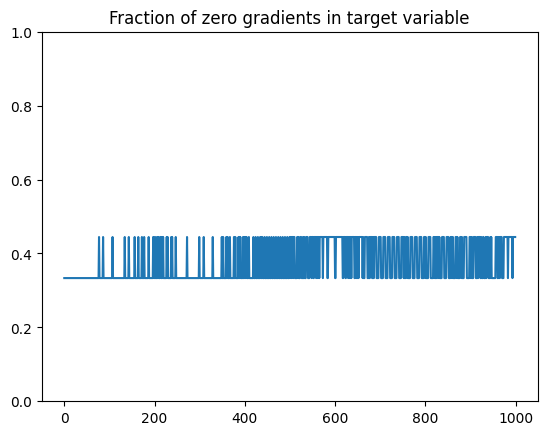

In [30]:
data = gradients.gradient_stats[selected_var_idx].to_numpy()
data = np.sum((data == 0.0), axis=-1) / data.shape[1]

plt.plot(data)
plt.title("Fraction of zero gradients in target variable")
plt.ylim([0.0, 1.0])
plt.show()

<ipython-input-14-97811f279160>:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


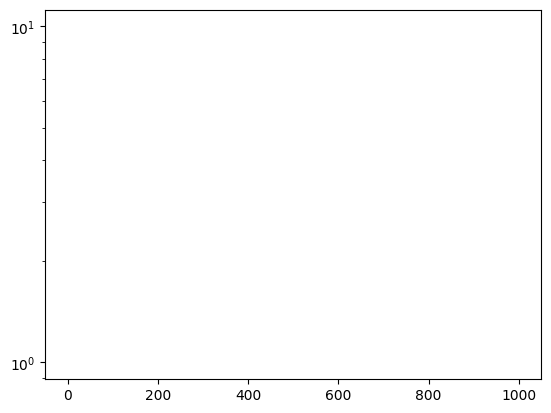

In [14]:
plt.plot(gradients.collected_gradient_stats[6][50])
#plt.yscale('log')
#plt.show()